## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [28]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

### Data Load

In [29]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_23.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_23.csv')

DI_train = pd.read_csv('../data/DI_train_dataset_23.csv')
DI_test = pd.read_csv('../data/DI_test_dataset_23.csv')

In [30]:
IVF_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250052 entries, 0 to 250051
Data columns (total 92 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      250052 non-null  object 
 1   시술_시기_코드                250052 non-null  object 
 2   시술_당시_나이                250052 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수   250052 non-null  object 
 4   배란_자극_여부                250052 non-null  int64  
 5   배란_유도_유형                250052 non-null  object 
 6   단일_배아_이식_여부             250052 non-null  float64
 7   착상_전_유전_검사_사용_여부        250052 non-null  float64
 8   착상_전_유전_진단_사용_여부        250052 non-null  float64
 9   남성_주_불임_원인              250052 non-null  int64  
 10  남성_부_불임_원인              250052 non-null  int64  
 11  여성_주_불임_원인              250052 non-null  int64  
 12  여성_부_불임_원인              250052 non-null  int64  
 13  부부_주_불임_원인              250052 non-null  int64  
 14  부부_부_불임_원인          

In [31]:
DI_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6290 entries, 0 to 6289
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     6290 non-null   object 
 1   시술_시기_코드               6290 non-null   object 
 2   시술_당시_나이               6290 non-null   object 
 3   임신_시도_또는_마지막_임신_경과_연수  6290 non-null   object 
 4   배란_자극_여부               6290 non-null   int64  
 5   남성_주_불임_원인             6290 non-null   int64  
 6   남성_부_불임_원인             6290 non-null   int64  
 7   여성_주_불임_원인             6290 non-null   int64  
 8   여성_부_불임_원인             6290 non-null   int64  
 9   부부_주_불임_원인             6290 non-null   int64  
 10  부부_부_불임_원인             6290 non-null   int64  
 11  불명확_불임_원인              6290 non-null   int64  
 12  불임_원인_-_난관_질환          6290 non-null   int64  
 13  불임_원인_-_남성_요인          6290 non-null   int64  
 14  불임_원인_-_배란_장애          6290 non-null   int64  
 15  불임_원

In [32]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

### 인코딩 

In [33]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "배아_생성_주요_이유",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "변환된_특정_시술_유형",
    "채취_해동_차이",
    "해동_혼합_차이",
    "혼합_이식_차이",
    "이식_해동_차이"
]

In [34]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [35]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [36]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

In [10]:
from imblearn.over_sampling import BorderlineSMOTE

# Borderline-SMOTE를 사용하여 소수 클래스 오버샘플링
borderline_smote = BorderlineSMOTE(random_state=42)
IVF_X_train_resampled, IVF_y_train_resampled = borderline_smote.fit_resample(IVF_X_train, IVF_y_train)
DI_X_train_resampled, DI_y_train_resampled = borderline_smote.fit_resample(DI_X_train, DI_y_train)

# 결과 확인
print("Original IVF dataset shape:", IVF_X_train.shape)
print("Resampled IVF dataset shape:", IVF_X_train_resampled.shape)
print("Original DI dataset shape:", DI_X_train.shape)
print("Resampled DI dataset shape:", DI_X_train_resampled.shape)

Original IVF dataset shape: (200041, 90)
Resampled IVF dataset shape: (295068, 90)
Original DI dataset shape: (5032, 34)
Resampled DI dataset shape: (8778, 34)


In [11]:
IVF_X_train = IVF_X_train_resampled
IVF_y_train = IVF_y_train_resampled
DI_X_train = DI_X_train_resampled
DI_y_train = DI_y_train_resampled

### IVF 데이터


--- Model Performance ---
Model Accuracy: 0.7346583751574653
Model F1 Score: 0.31541477507222454
Model AUC: 0.7322465778624904


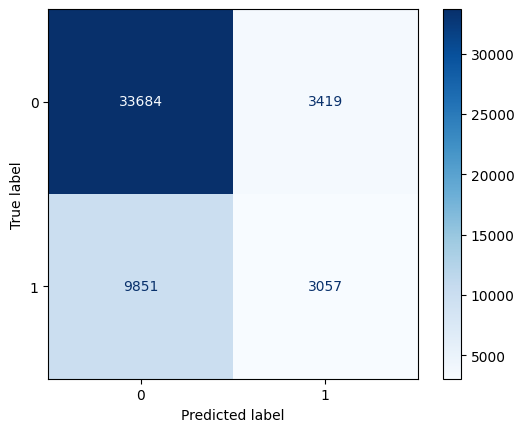

In [12]:
# 모델 초기화
IVF_model = lgb.LGBMClassifier(
    n_estimators=4156,
    num_leaves=272,
    max_depth=176,
    learning_rate=0.0007995510048474224,
    min_child_samples=68,
    subsample=0.6633508877467796,
    colsample_bytree=0.5853848362807443,
    reg_alpha=0.07726565607460635,
    reg_lambda=0.005106720855198981,
    min_split_gain=0.03110228802819453,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
IVF_model.fit(IVF_X_train, IVF_y_train)

# 예측
y_pred = IVF_model.predict(IVF_X_test)
y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

# 평가
accuracy = accuracy_score(IVF_y_test, y_pred)
f1 = f1_score(IVF_y_test, y_pred)
auc = roc_auc_score(IVF_y_test, y_pred_proba)
cm = confusion_matrix(IVF_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### DI 데이터


--- Model Performance ---
Model Accuracy: 0.7098569157392687
Model F1 Score: 0.33027522935779813
Model AUC: 0.7138624945391


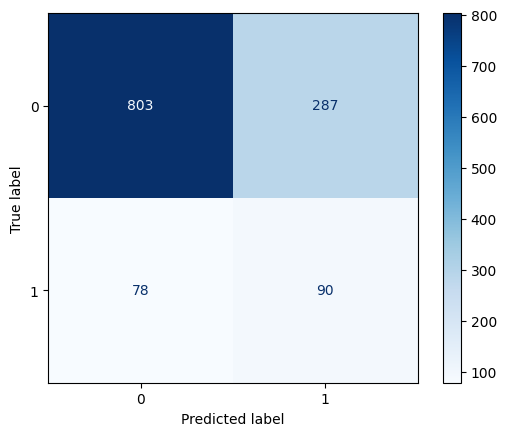

In [19]:
# 모델 초기화
DI_model = lgb.LGBMClassifier(
    n_estimators=2165,
    num_leaves=11,
    max_depth=435,
    learning_rate=0.00012585592535695468,
    min_child_samples=84,
    subsample=0.842167890007842,
    colsample_bytree=0.9326904172797006,
    reg_alpha=1.9278804523967218e-07,
    reg_lambda=0.6793469461517738,
    min_split_gain=1.465590748566115e-08,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
DI_model.fit(DI_X_train, DI_y_train)

# 예측
y_pred = DI_model.predict(DI_X_test)
y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 평가
accuracy = accuracy_score(DI_y_test, y_pred)
f1 = f1_score(DI_y_test, y_pred)
auc = roc_auc_score(DI_y_test, y_pred_proba)
cm = confusion_matrix(DI_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


--- Model Performance ---
Model Accuracy: 0.7478008153074958
Model F1 Score: 0.3583126550868486
Model AUC: 0.7489969807833965


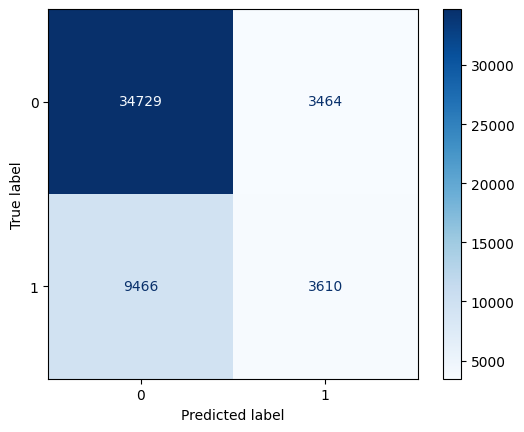

In [20]:
# 예측
IVF_y_pred = IVF_model.predict(IVF_X_test)
IVF_y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

DI_y_pred = DI_model.predict(DI_X_test)
DI_y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

데이콘 PUBLIC 0.722582299

## 제출

In [37]:
from imblearn.over_sampling import BorderlineSMOTE
import pandas as pd

# Borderline-SMOTE를 사용하여 소수 클래스 오버샘플링
borderline_smote = BorderlineSMOTE(random_state=42)
IVF_X_resampled, IVF_y_resampled = borderline_smote.fit_resample(IVF_X, IVF_y)
DI_X_resampled, DI_y_resampled = borderline_smote.fit_resample(DI_X, DI_y)

# 결과 확인
print("Original IVF dataset shape:", IVF_X.shape)
print("Resampled IVF dataset shape:", IVF_X_resampled.shape)
print("Original DI dataset shape:", DI_X.shape)
print("Resampled DI dataset shape:", DI_X_resampled.shape)

Original IVF dataset shape: (250052, 90)
Resampled IVF dataset shape: (369274, 90)
Original DI dataset shape: (6290, 34)
Resampled DI dataset shape: (10958, 34)


In [38]:
IVF_X = IVF_X_resampled
IVF_y = IVF_y_resampled
DI_X = DI_X_resampled
DI_y = DI_y_resampled

In [39]:
# 모델 학습 및 예측
IVF_model.fit(IVF_X, IVF_y)
IVF_pred_proba = IVF_model.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]

DI_model.fit(DI_X, DI_y)
DI_pred_proba = DI_model.predict_proba(DI_test.drop('ID', axis=1))[:, 1]

In [40]:
# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')  

# 제출 파일 저장
submission.to_csv('../submission/code23_sampling_border_submit02.csv', index=False, encoding='utf-8')

.